# Multi- Layer Perceptron

Modified from https://github.com/AgrawalAmey/nnfl-resources


# Study and optimize an implementation of a Multi-Layer Perceptron from scratch
* We start from an implementation of a MPL with vanilla  Back-Propagation Learning using sigmoidal units.
* The cost function is the root mean square
* Input data are normalized before training
* It is trained on 5 synthetic bidimensional data sets
* No cross-validation is implemented.

You may prepare a different notebook for each item.

### Part A :
1. For each data set find the minimal NN architecture. You should set the number of layers, the number of neurons for each layer,  the initialization of weights and bias, the dimension of the mini-batchs, the number of iterations, the learning rate. Discuss your results.
2. Plot the learning curve
3. Augment the input layer in order to improve learning (e.g., introduce a new synthetic input as the sum of the squares of the two actual inputs: $z=x^2+y^2$). Discuss your results.

### Part B:  (at least one of the following)
4. Increase the size of your NN and implement weigth decay. Discuss your results.
5. Implement drop-out. Discuss your results.
6. Implement layers normalization. Discuss your results.
7. Implement train with noise. Discuss your results.
8. Change the activation function and its derivative (e.g., try with ReLu). Discuss your results.

In [1]:
# Library imports
import random
import numpy as np
import pandas as pd
import jdc
import sklearn
import time
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_circles, make_moons, \
                             make_blobs, make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

def generate_datsets():
    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============

    np.random.seed(0)
    
    # >>>
    # n_samples = 1500
    n_samples = 5000

    datasets = {}

    datasets['noisy_circles'] = make_circles(n_samples=n_samples, factor=.5,
                                             noise=.05)
    datasets['noisy_moons'] = make_moons(n_samples=n_samples, noise=.05)
    datasets['blobs'] = make_blobs(n_samples=n_samples, random_state=8)
    datasets['linearly_separable'] = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                                         n_informative=2, random_state=1, n_clusters_per_class=1)
    # Anisotropicly distributed data
    random_state = 170
    X, y = make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    datasets['aniso'] = (X_aniso, y)

    # blobs with varied variances
    datasets['varied'] = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
    
    return datasets

def plot_datasets(datasets):
    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(2.3 * len(datasets) - 0.3, 4.3))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    dataset_num = 1

    for name, dataset in datasets.items():
        X = dataset[0]
        Ys = dataset[1:]

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
        
        for i in range(len(Ys)):
            plt.subplot(2, len(datasets), dataset_num + i * len(datasets))

            if i == 0:
                plt.title(name)

            colors = np.array(list(islice(cycle(flatui), int(max(Ys[i]) + 1))))
            plt.scatter(X[:, 0], X[:, 1], s=5, c=colors[Ys[i]])            
            
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())

        dataset_num += 1

    plt.show()

In [26]:
# This code is for plotting data in the way I have created
def plot_data(datasets):
    # ============
    # Set up cluster parameters
    # ============
    dataset_num = 0
    fig, axs = plt.subplots(17,6,figsize=(30, 60))
    for name, dataset in datasets.items():
        X = dataset[0]
        Ys = dataset[1:]

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)
        flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
        colors = np.array(list(islice(cycle(flatui), int(max(dataset[1]) + 1))))
        axs[0,dataset_num].scatter(X[:, 0], X[:, 1], s=5, c=colors[dataset[1]])
        axs[0,dataset_num].set_title(str("Dataset Name : ")+name)
        for i in range(len(dataset[2])):
            colors = np.array(list(islice(cycle(flatui), int(max(dataset[2][i][1]) + 1))))
            axs[i+1,dataset_num].scatter(X[:, 0], X[:, 1], s=5, c=colors[dataset[2][i][1]])
            axs[i+1,dataset_num].set_ylabel(dataset[2][i][0])            

        dataset_num += 1

    plt.show()  

In [4]:
# use this function to Augment the input layer in order to improve learning (z = x**2 + y**2)
def im_au(X):
    au = np.zeros([len(X),1])
    for i in range(len(X)):
        au[i] = X[i][0]**2 + X[i][1]**2
    au = np.append(X,au,axis=1)
    return au
        

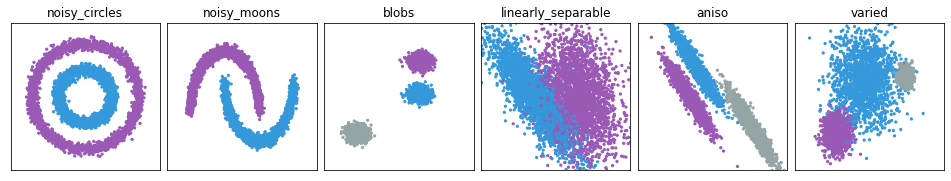

In [5]:
datasets = generate_datsets()

plot_datasets(datasets)

In [19]:
class Network(object):

    def __init__(self, sizes,act_func):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network. For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.act_func = act_func
        self.initialize_biases()
        self.initialize_weights()
        
    def initialize_biases(self):
        # >>>
        self.biases = [ np.random.randn(y, 1) for y in self.sizes[1:]]

    def initialize_weights(self):
        # >>>
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def train(self, training_data, epochs, mini_batch_size, learning_rate):
        """Train the neural network using gradient descent.  
        ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired
        outputs.  The other parameters are self-explanatory."""

        # training_data is a list and is passed by reference
        # To prevent affecting the original data we use 
        # this hack to create a copy of training_data
        # https://stackoverflow.com/a/2612815
        training_data = list(training_data)
        cost_ar = np.zeros(epochs)
        acc_ar = np.zeros(epochs)
        for i in range(epochs):
            # Get mini-batches    
            mini_batches = self.create_mini_batches(training_data, mini_batch_size)

            # Iterate over mini-batches to update parameters   
            cost = sum(map(lambda mini_batch: self.update_params(mini_batch, learning_rate), mini_batches))

            # Find accuracy of the model at the end of epoch         
            acc = self.evaluate(training_data)

            # >>> if ((i//10)*10 ==i):
            # print("Epoch {} complete. Total cost: {}, Accuracy: {}".format(i, cost, acc))
            cost_ar[i] = cost
            acc_ar[i] = acc
        return cost_ar, acc_ar

    def create_mini_batches(self, training_data, mini_batch_size):
        # Shuffling data helps a lot in mini-batch SGD
        random.shuffle(training_data)

        mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, len(training_data), mini_batch_size)]

        return mini_batches
    
    def update_params(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation."""

        # Initialize gradients     
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]

        total_cost = 0

        for x, y in mini_batch:
            # Obtain the mean squared error and the gradients
            # with resepect to biases and weights        
            cost, del_b, del_w = self.backprop(x, y)

            # Add the gradients for each sample in mini-batch        
            delta_b = [nb + dnb for nb, dnb in zip(delta_b, del_b)]
            delta_w = [nw + dnw for nw, dnw in zip(delta_w, del_w)]

            total_cost += cost

        # Update self.biases and self.weights
        # using delta_b, delta_w and learning_rate    
        self.biases = [b - (learning_rate / len(mini_batch)) * db
                       for b, db in zip(self.biases, delta_b)]
        self.weights = [w - (learning_rate / len(mini_batch)) * dw
                        for w, dw in zip(self.weights, delta_w)]

        return total_cost
    
    def backprop(self, x, y):
        """Return array containing cost, del_b, del_w representing the
        cost function C(x) and gradient for cost function.  ``del_b`` and
        ``del_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        # Forward pass
        zs, activations = self.forward(x)

        # Backward pass     
        cost, del_b, del_w = self.backward(activations, zs, y)

        return cost, del_b, del_w
    #------------------------------------------ ReLu -----------------------------
    # Leaky ReLu
    def ReLu(self, z):
        """The ReLu function."""
        
        return np.maximum(z, 0)
    def ReLu_derivative(self, z):
        """Derivative of the ReLu function."""
        z[z>0]=1
        z[z<0]=0
        return z
    #------------------------------------------------------------------------------    
    def sigmoid(self, z):
        """The sigmoid function."""
        return 1.0 / (1.0 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        """Derivative of the sigmoid function."""

        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, x):
        """Compute Z and activation for each layer."""

        # list to store all the activations, layer by layer
        zs = []

        # current activation
        activation = x
        # list to store all the activations, layer by layer
        activations = [x]

        # Loop through each layer to compute activations and Zs    
        for b, w in zip(self.biases, self.weights):
            # YOUR CODE HERE
            # Calculate z
            # watch out for the dimensions of multiplying matrices         
            z = np.dot(w, activation) + b
            zs.append(z)
            # Calculate activation
            if self.act_func == 'ReLu':
                activation = self.ReLu(z)
            elif self.act_func == 'sigmoid':
                activation = self.sigmoid(z)
            activations.append(activation)

        return zs, activations
    
    def mse(self, output_activations, y):
        """Returns mean square error."""

        return sum((output_activations - y) ** 2 / 2)
    
    def mse_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations. """

        return (output_activations - y)
    
    def backward(self, activations, zs, y):
        """Compute and return cost function, gradients for 
        weights and biases for each layer."""
        # Initialize gradient arrays
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]

        # Compute for last layer
        cost = self.mse(activations[-1], y)

        if self.act_func == 'ReLu':
                delta = self.mse_derivative(activations[-1], y) * \
                        self.ReLu_derivative(zs[-1])
        elif self.act_func == 'sigmoid':
                delta = self.mse_derivative(activations[-1], y) * \
                        self.sigmoid_derivative(zs[-1])
        
        
        del_b[-1] = delta
        del_w[-1] = np.dot(delta, activations[-2].transpose())

        # Loop through each layer in reverse direction to 
        # populate del_b and del_w   
        for l in range(2, self.num_layers):
            z = zs[-l]
            
            if self.act_func == 'ReLu':
                activation = self.ReLu(z)
                sp = self.ReLu_derivative(z)
            elif self.act_func == 'sigmoid':
                activation = self.sigmoid(z)
                sp = self.sigmoid_derivative(z)
        
            
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            del_b[-l] = delta
            del_w[-l] = np.dot(delta, activations[-l -1].transpose())

        return cost, del_b, del_w
    
    def evaluate(self, test_data):
        """Return the accuracy of Network. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.forward(x)[1][-1]), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results) * 100 / len(test_results)
    

In [20]:
def pre_process_data(x, y):
    # Find number samples     
    n = len(y)
    # Find number classes
    c  = max(y) + 1
    
    # Normalize the input     
    x = sklearn.preprocessing.normalize(x)

    x = np.split(x, n)
    x = [a.reshape(-1, 1) for a in x]
    
    # Convert lables to one-hot vectors     
    one_hot = np.zeros([n, c])
    one_hot[range(n), y] = 1
    
    y = np.split(one_hot, n)
    y = [a.reshape(-1, 1) for a in y]
    
    return list(zip(x, y))


 Training dataset: noisy_circles

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 -

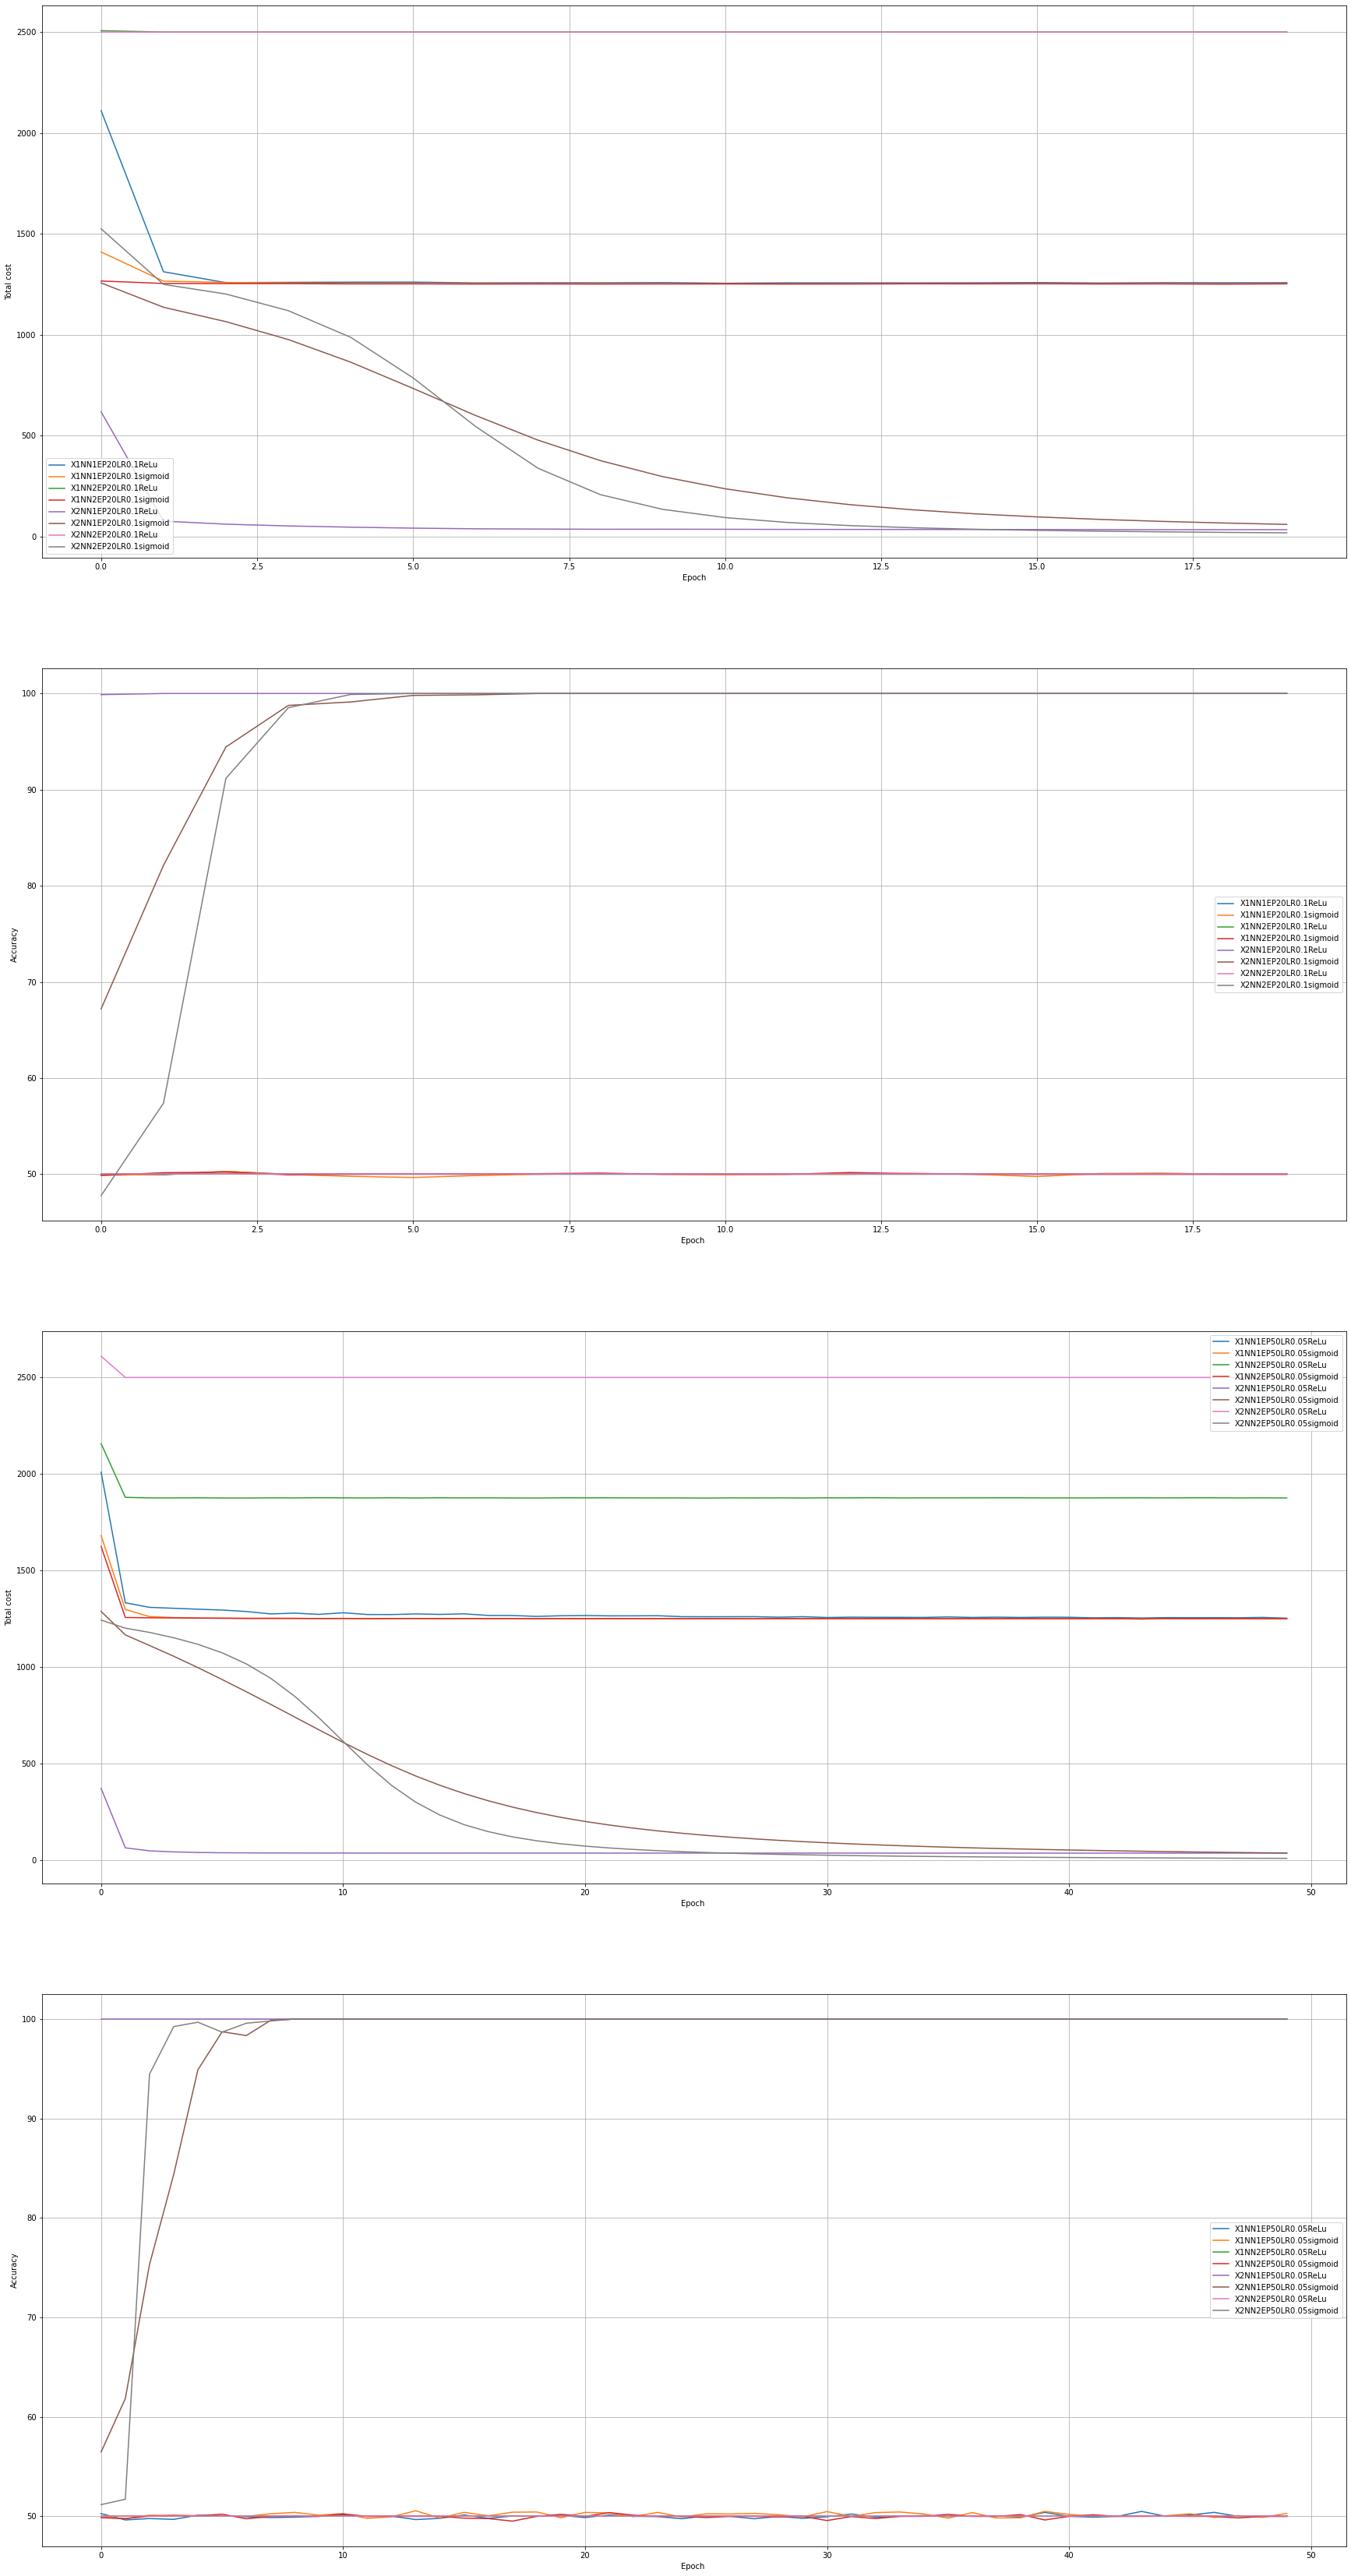


 Training dataset: noisy_moons

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - L

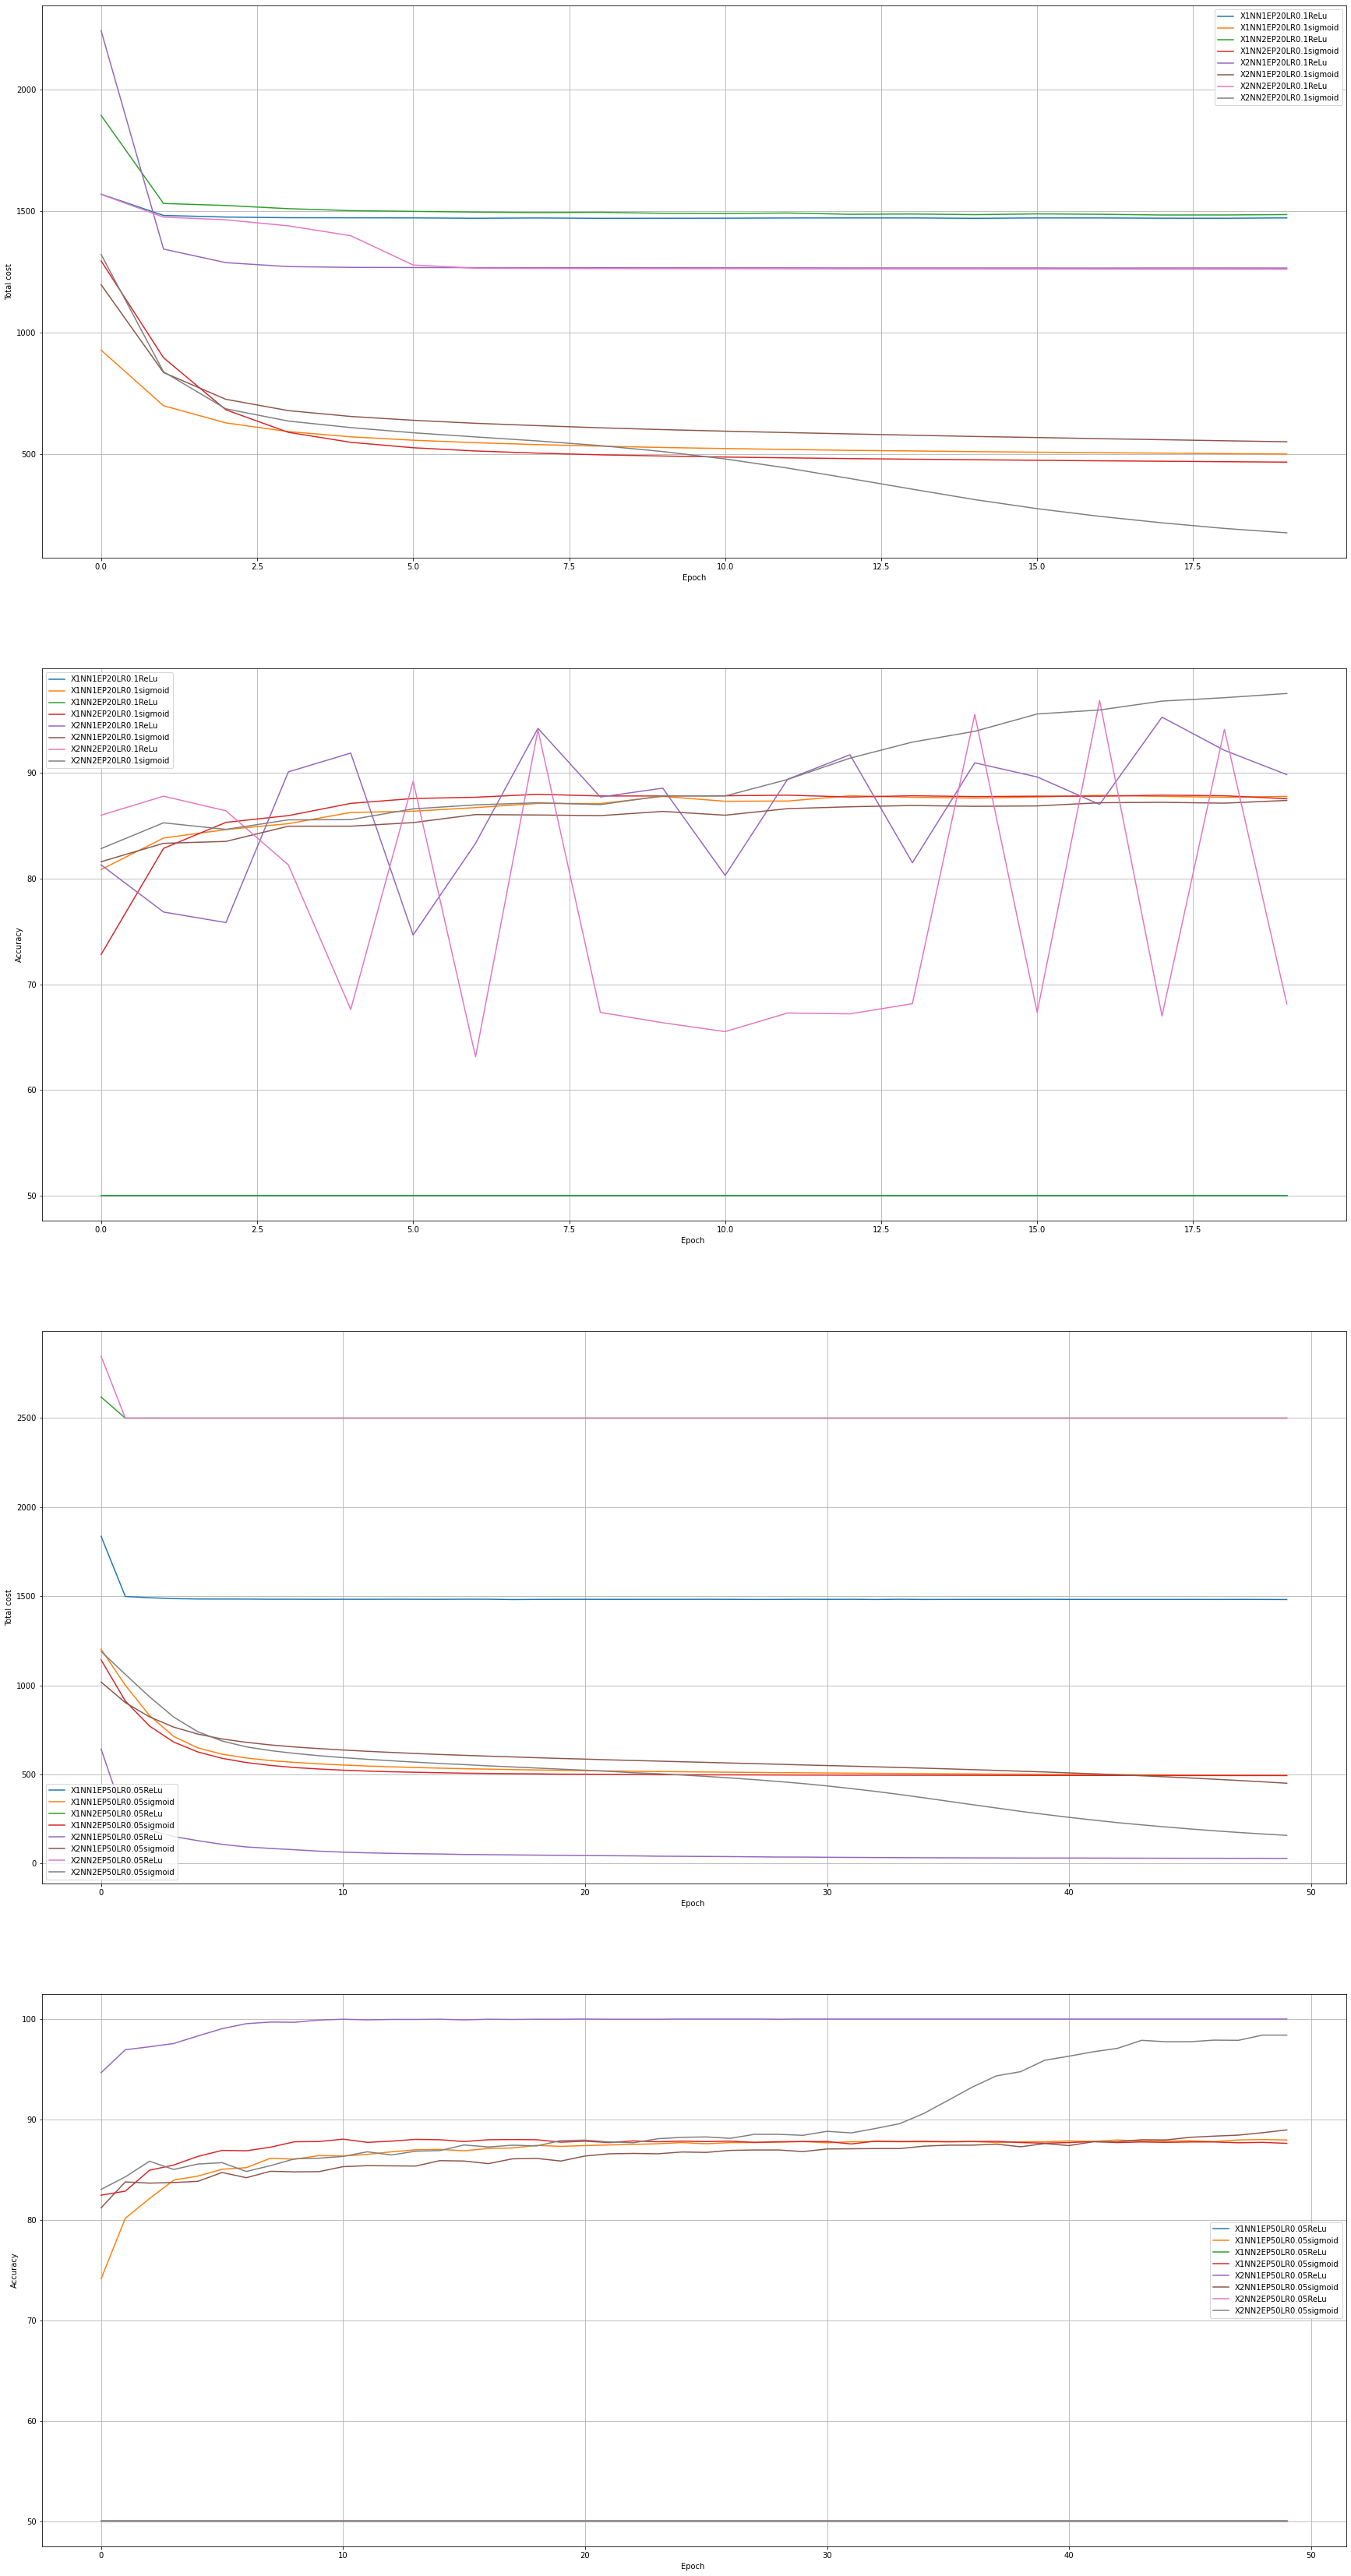


 Training dataset: blobs

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learnin

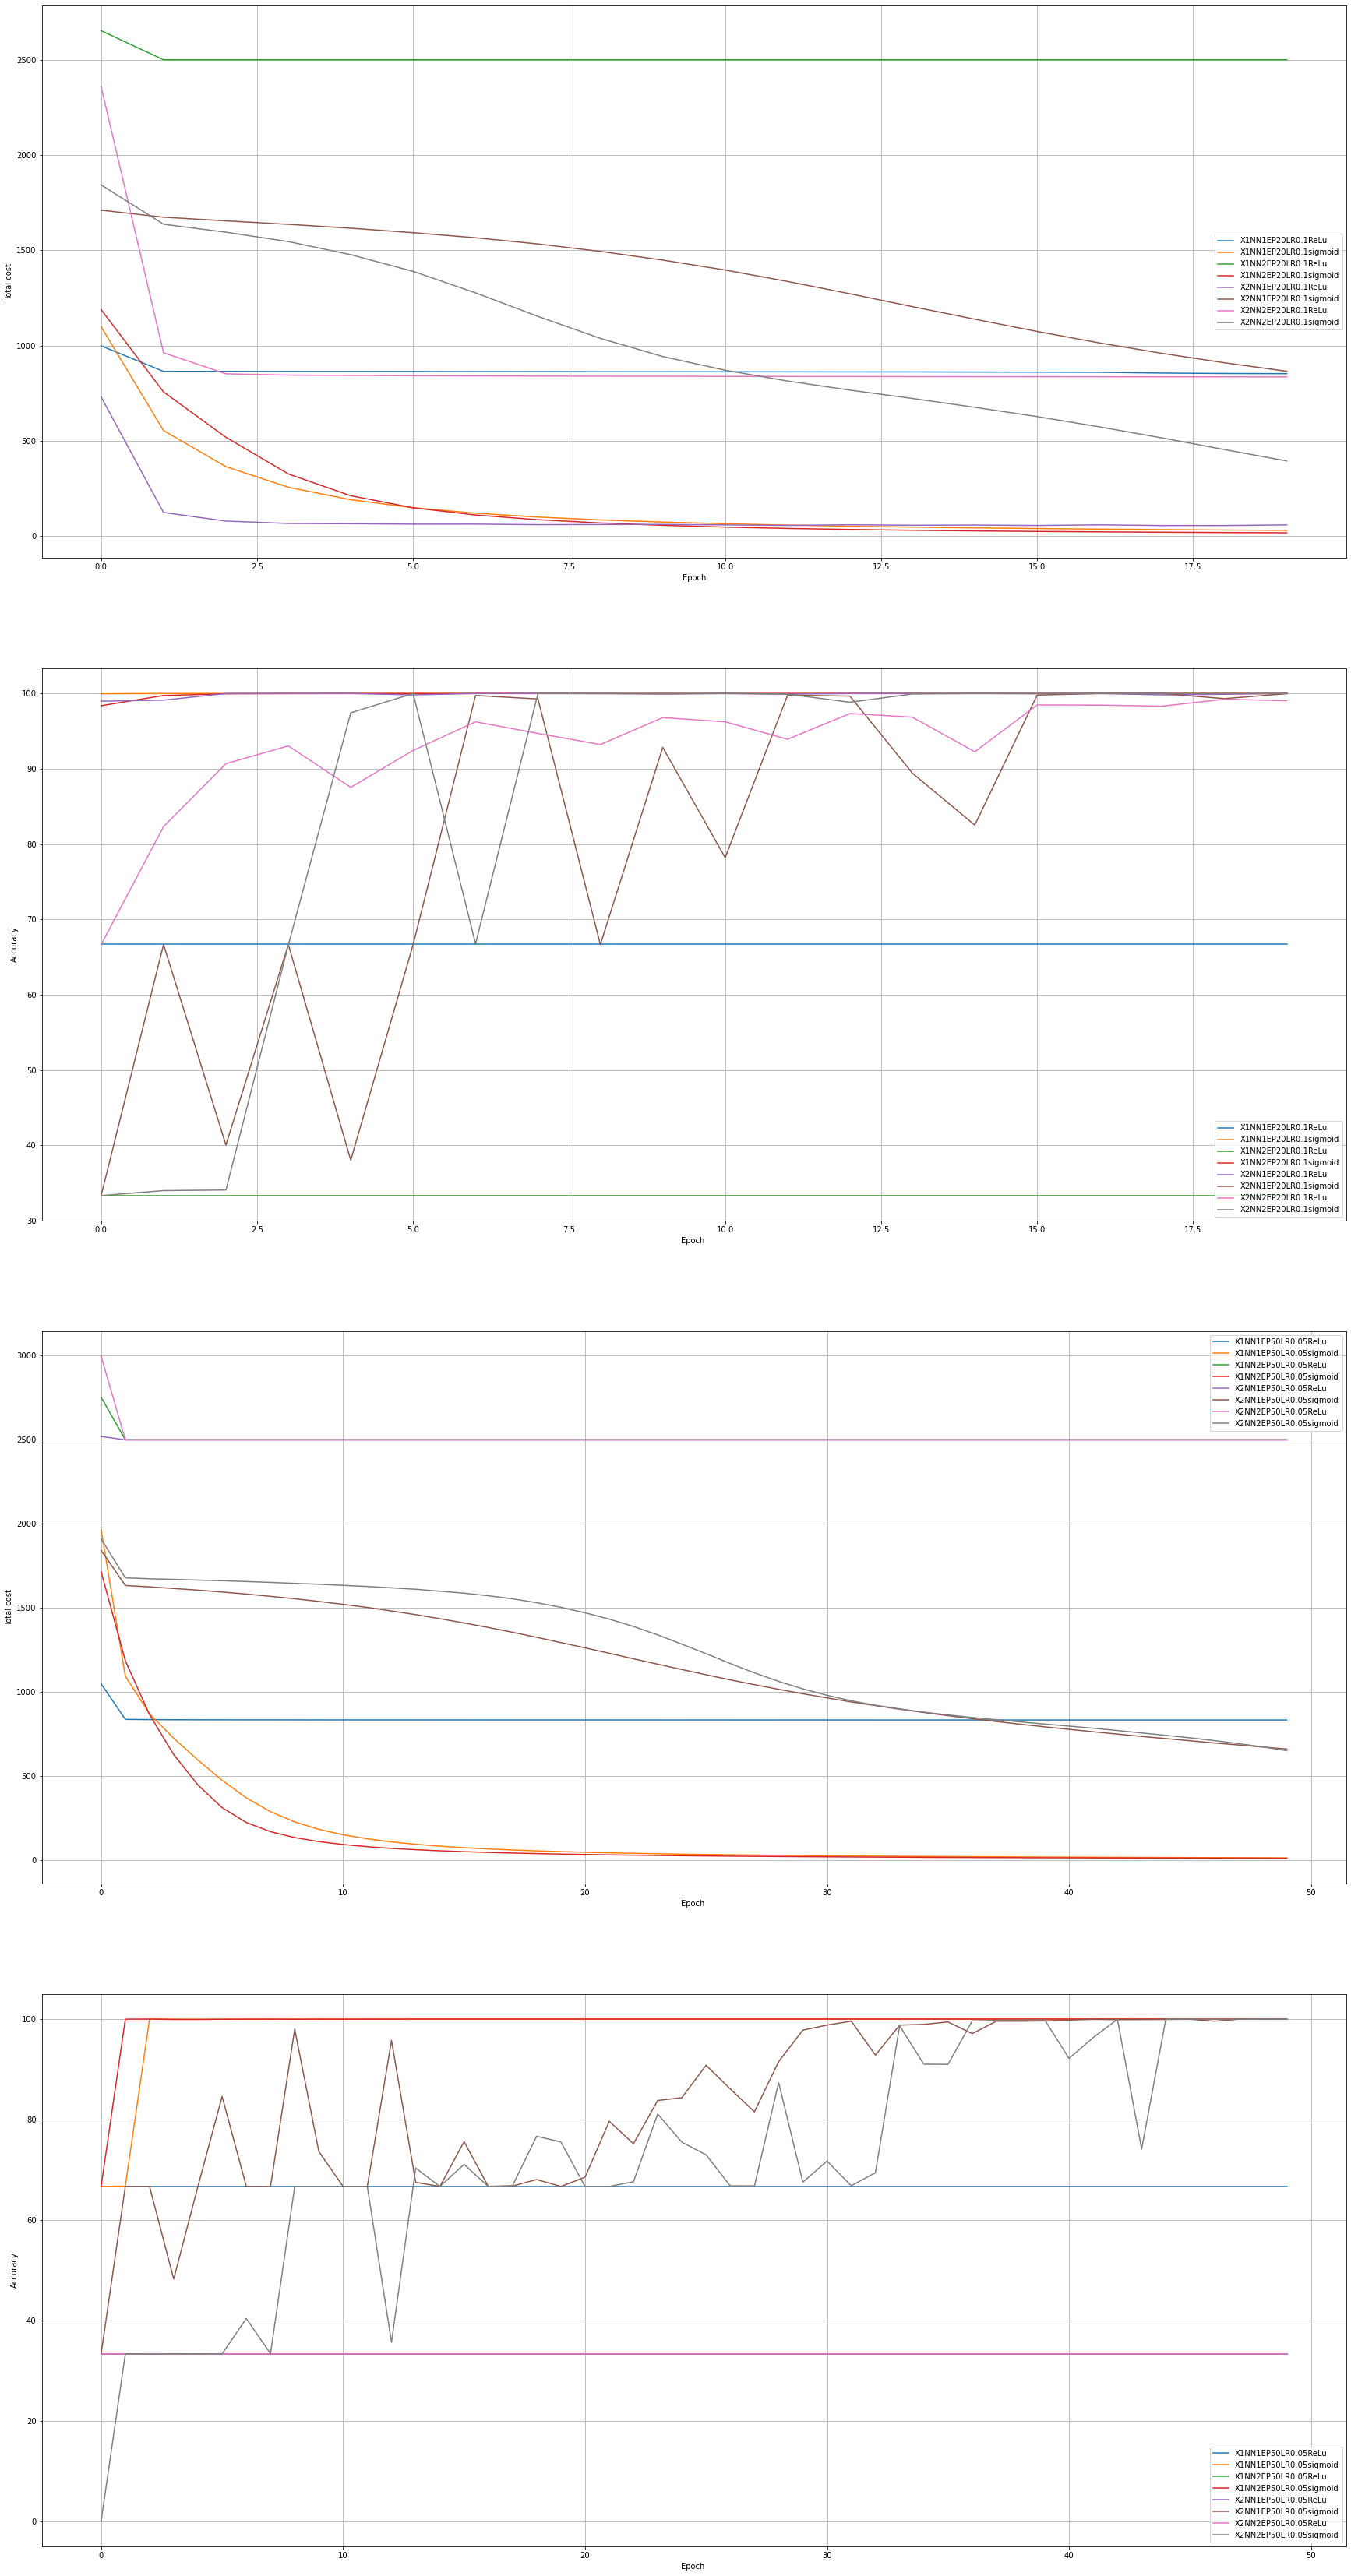


 Training dataset: linearly_separable

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs :

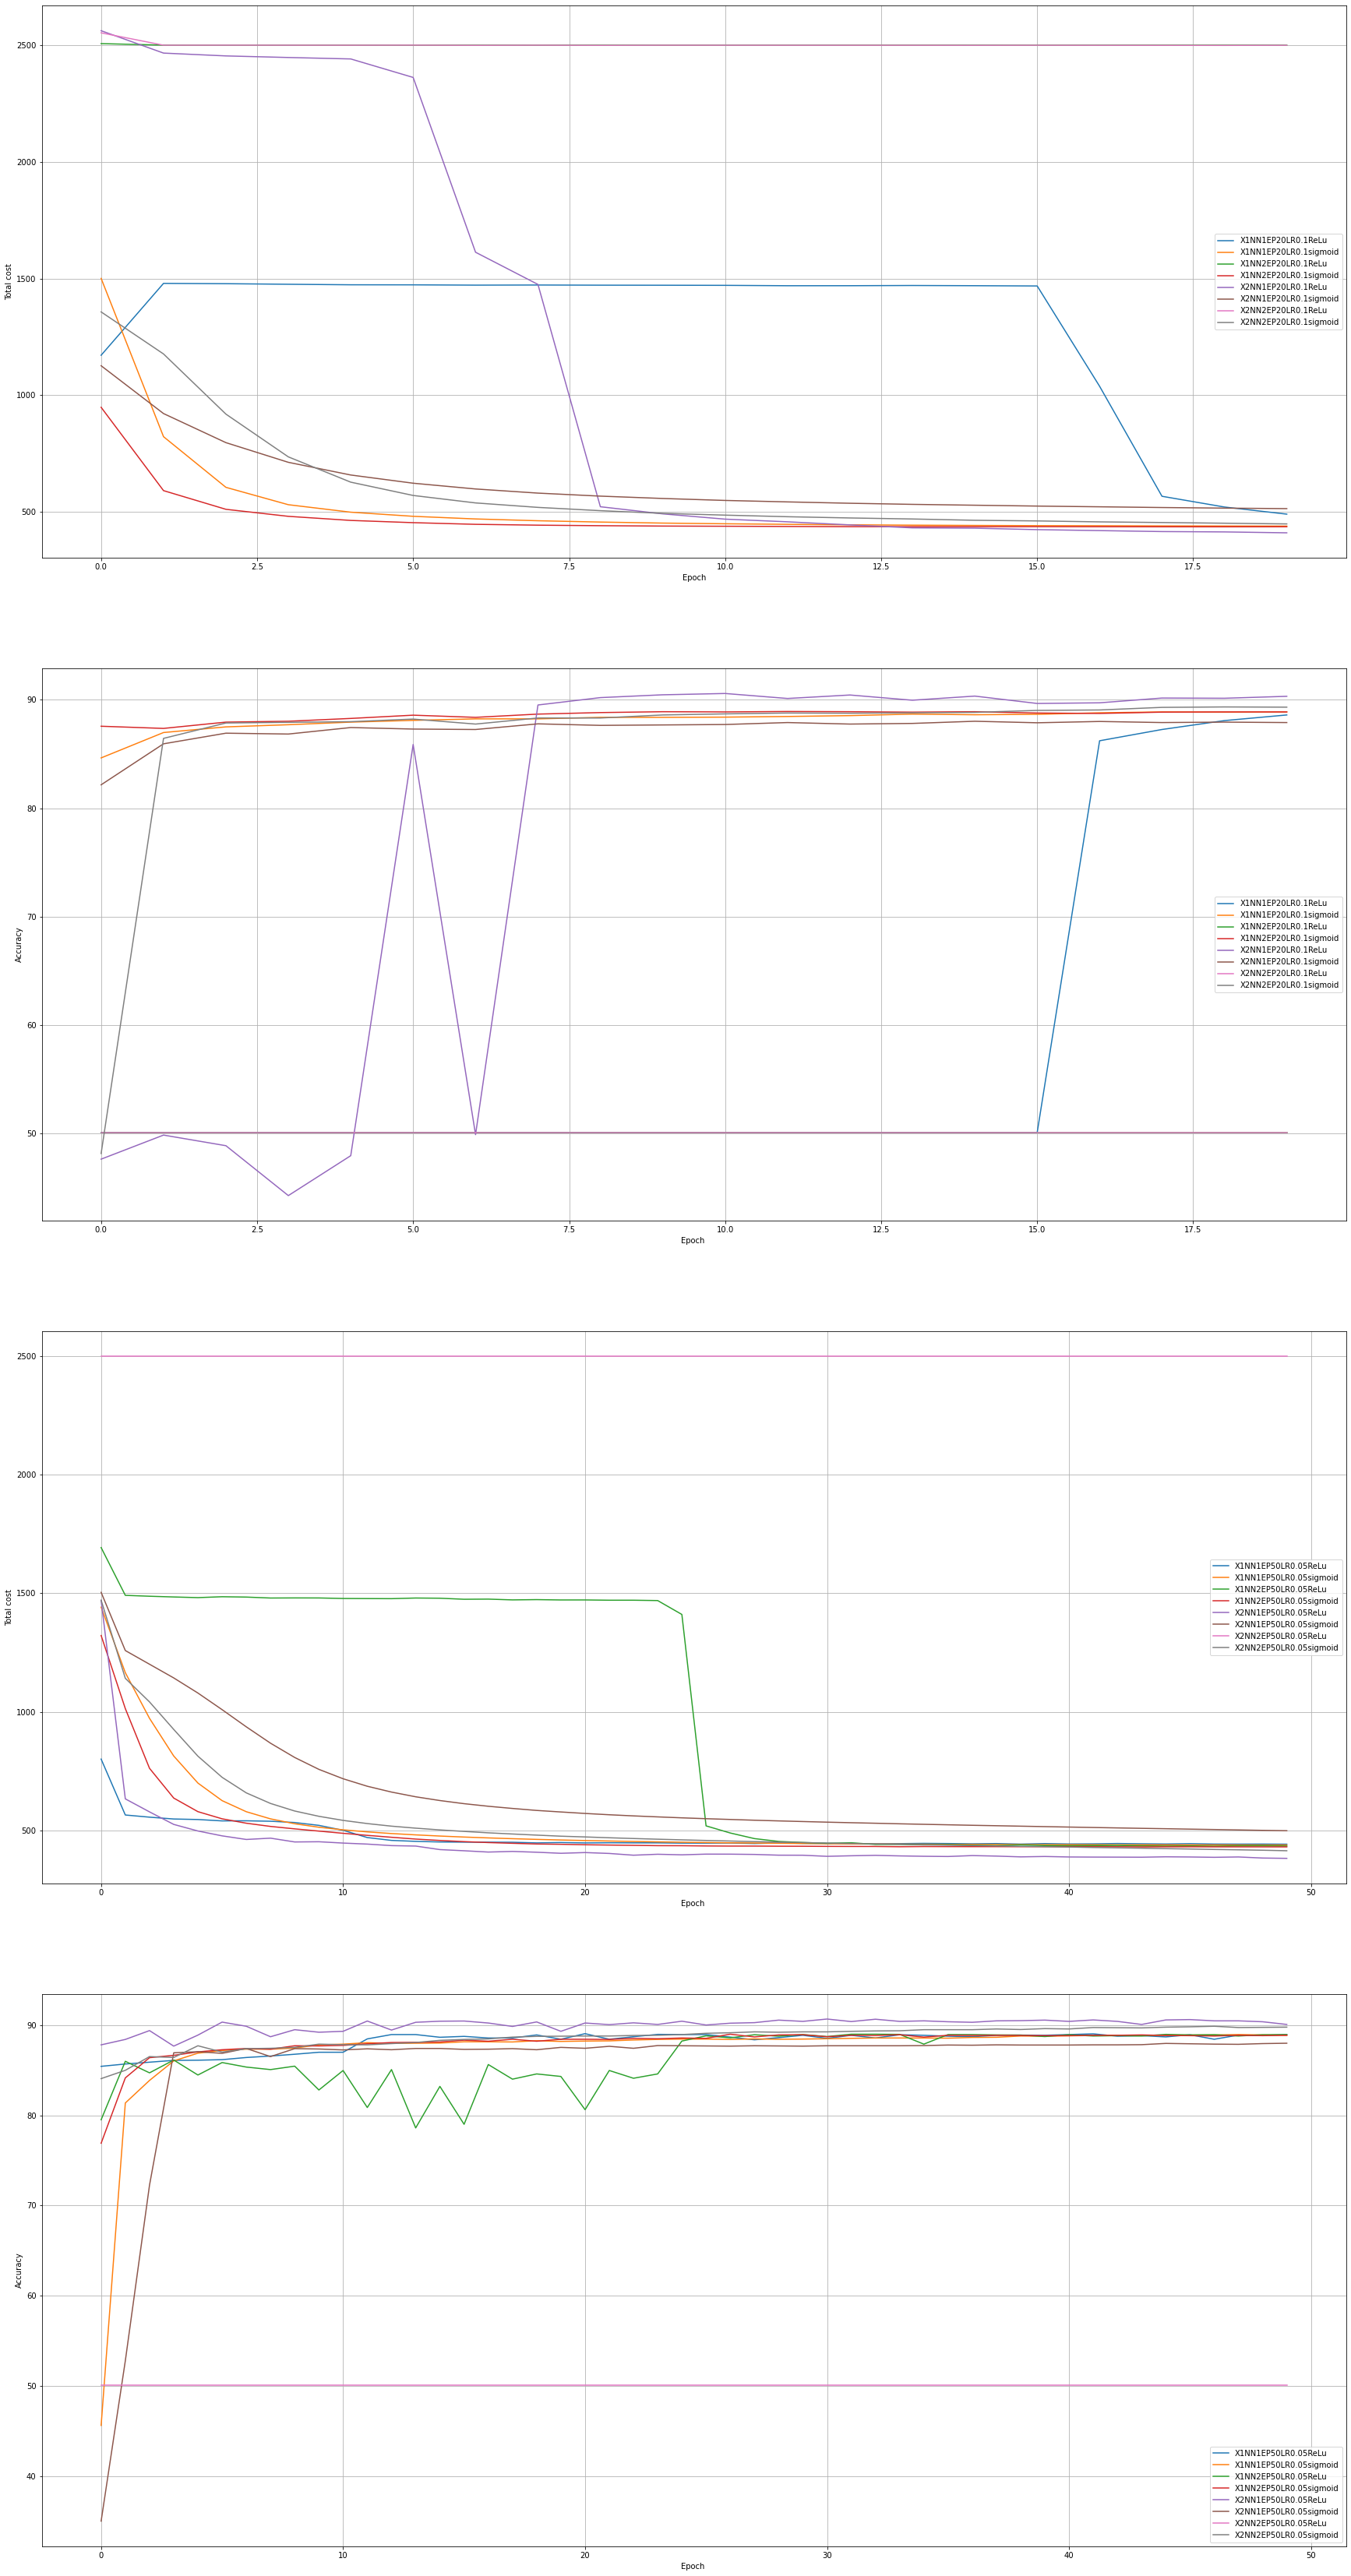


 Training dataset: aniso

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learnin

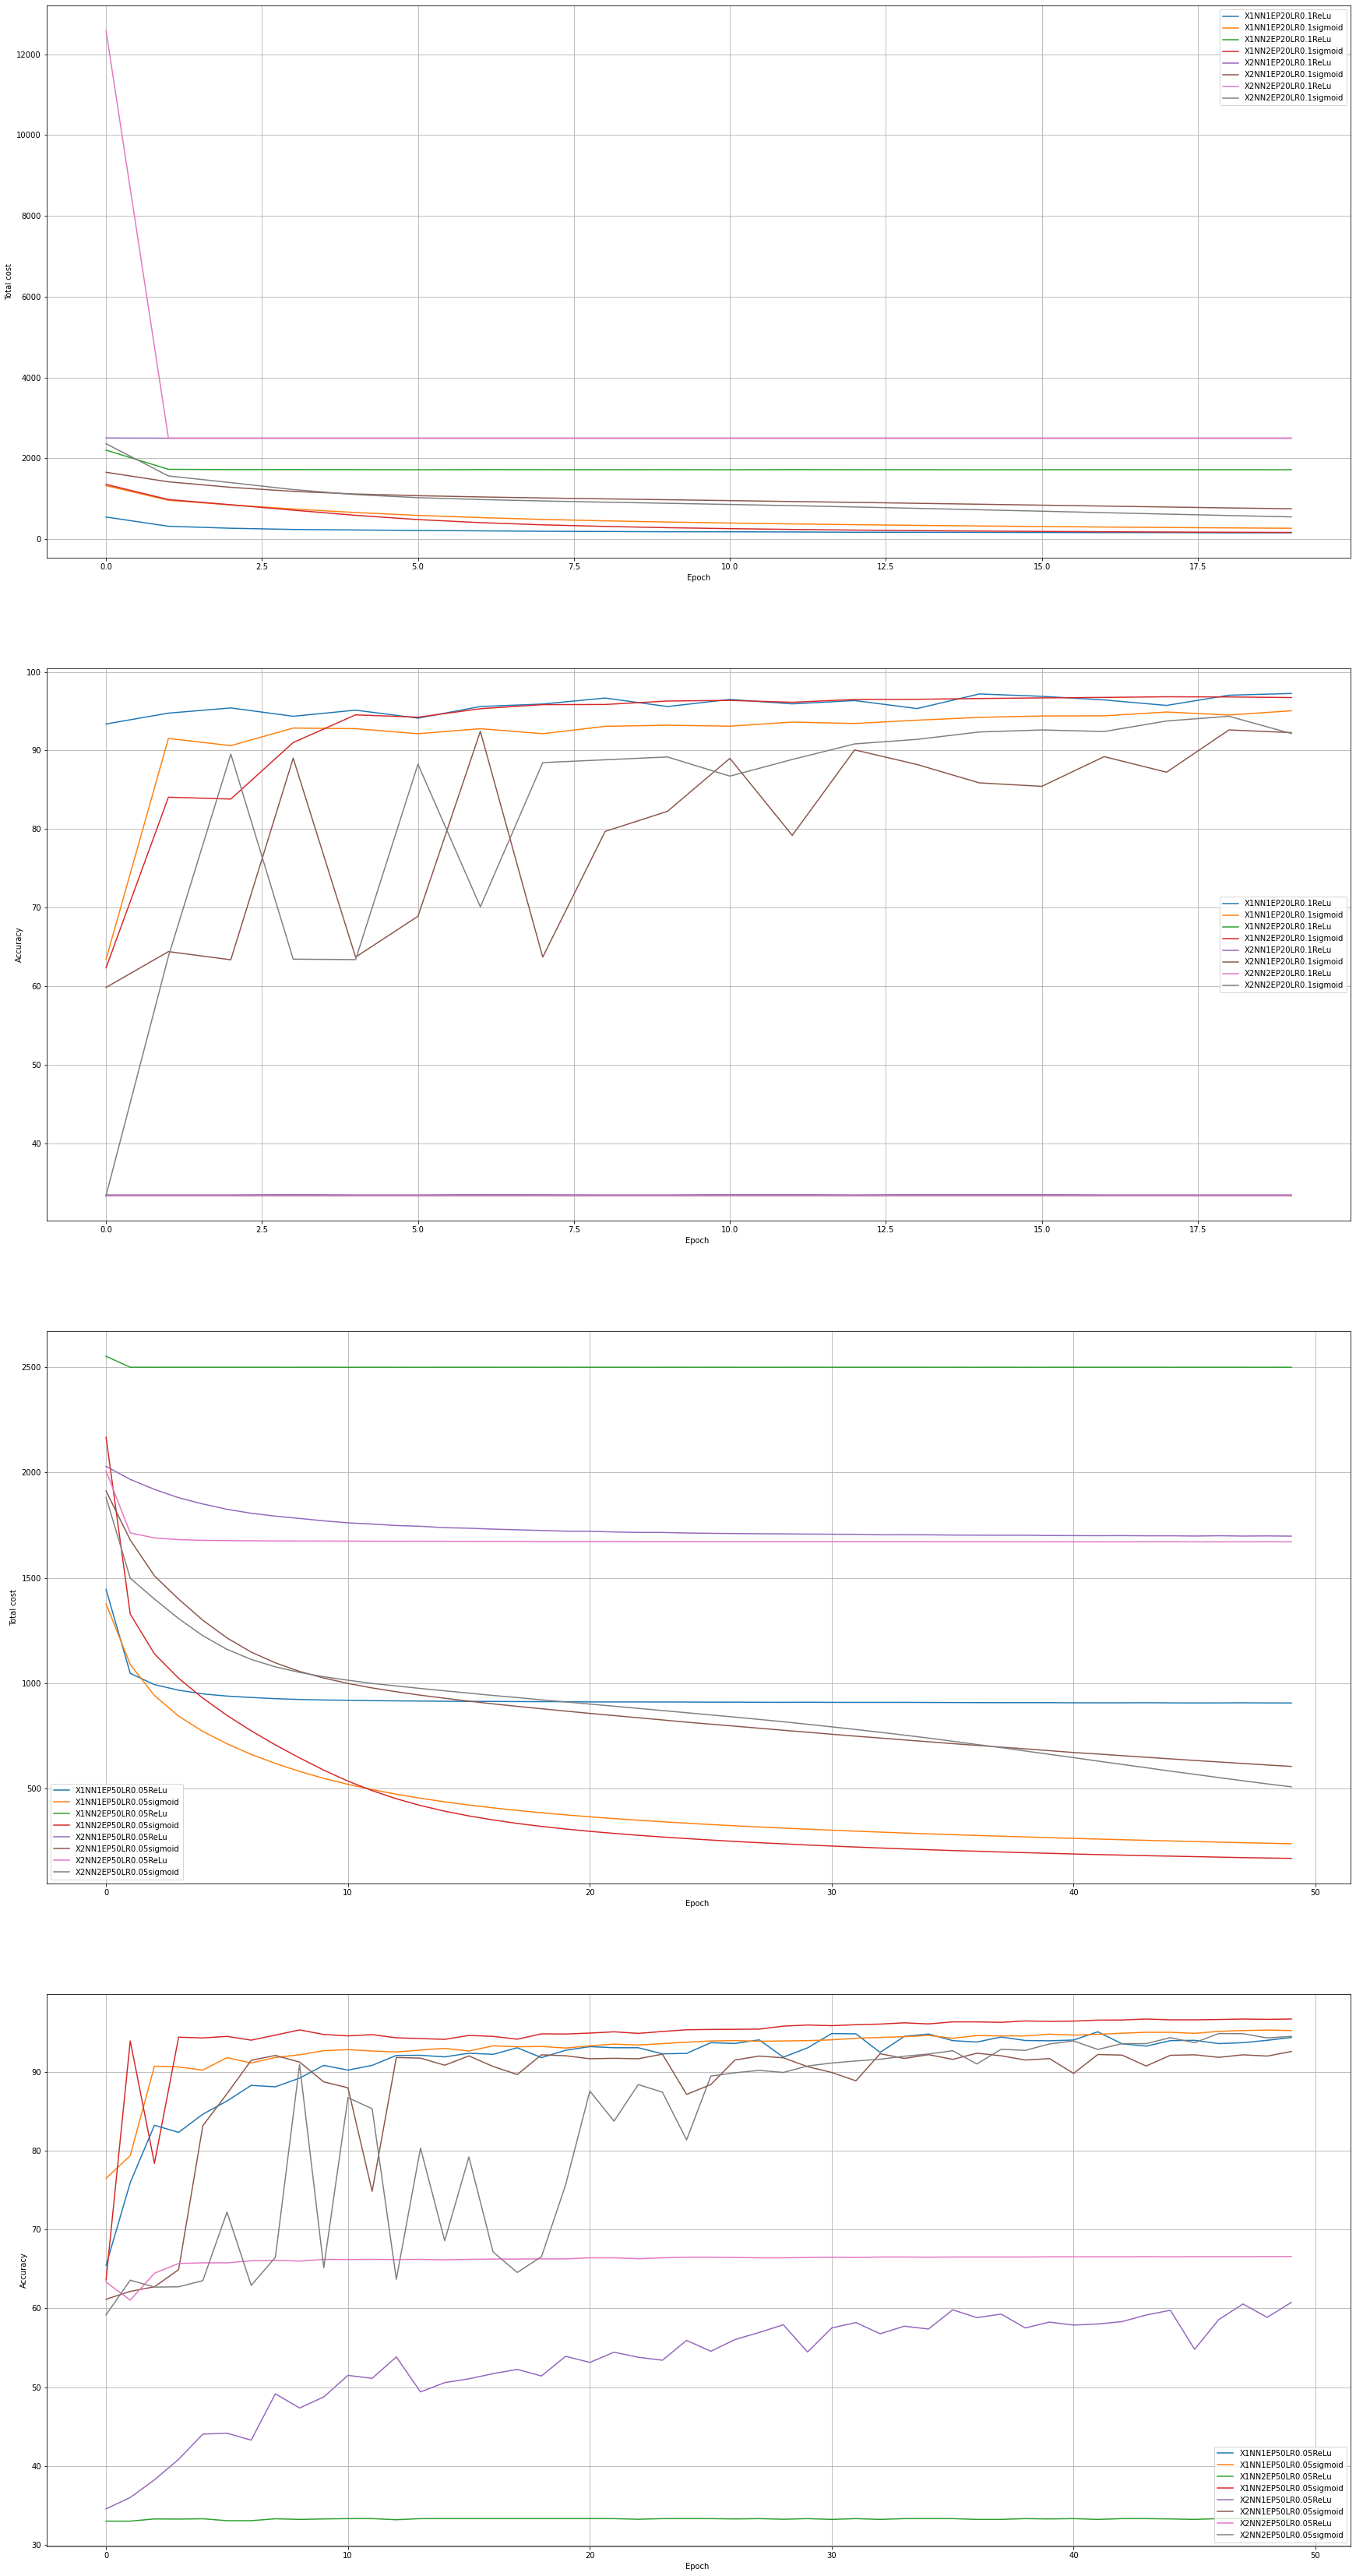


 Training dataset: varied

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 1 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : sigmoid

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : ReLu

 Runnung X : 1 - NN : 2 - Number of Epochs : 50 - Learning Rate : 0.05 - Activation Function : sigmoid

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learning Rate : 0.1 - Activation Function : ReLu

 Runnung X : 2 - NN : 1 - Number of Epochs : 20 - Learni

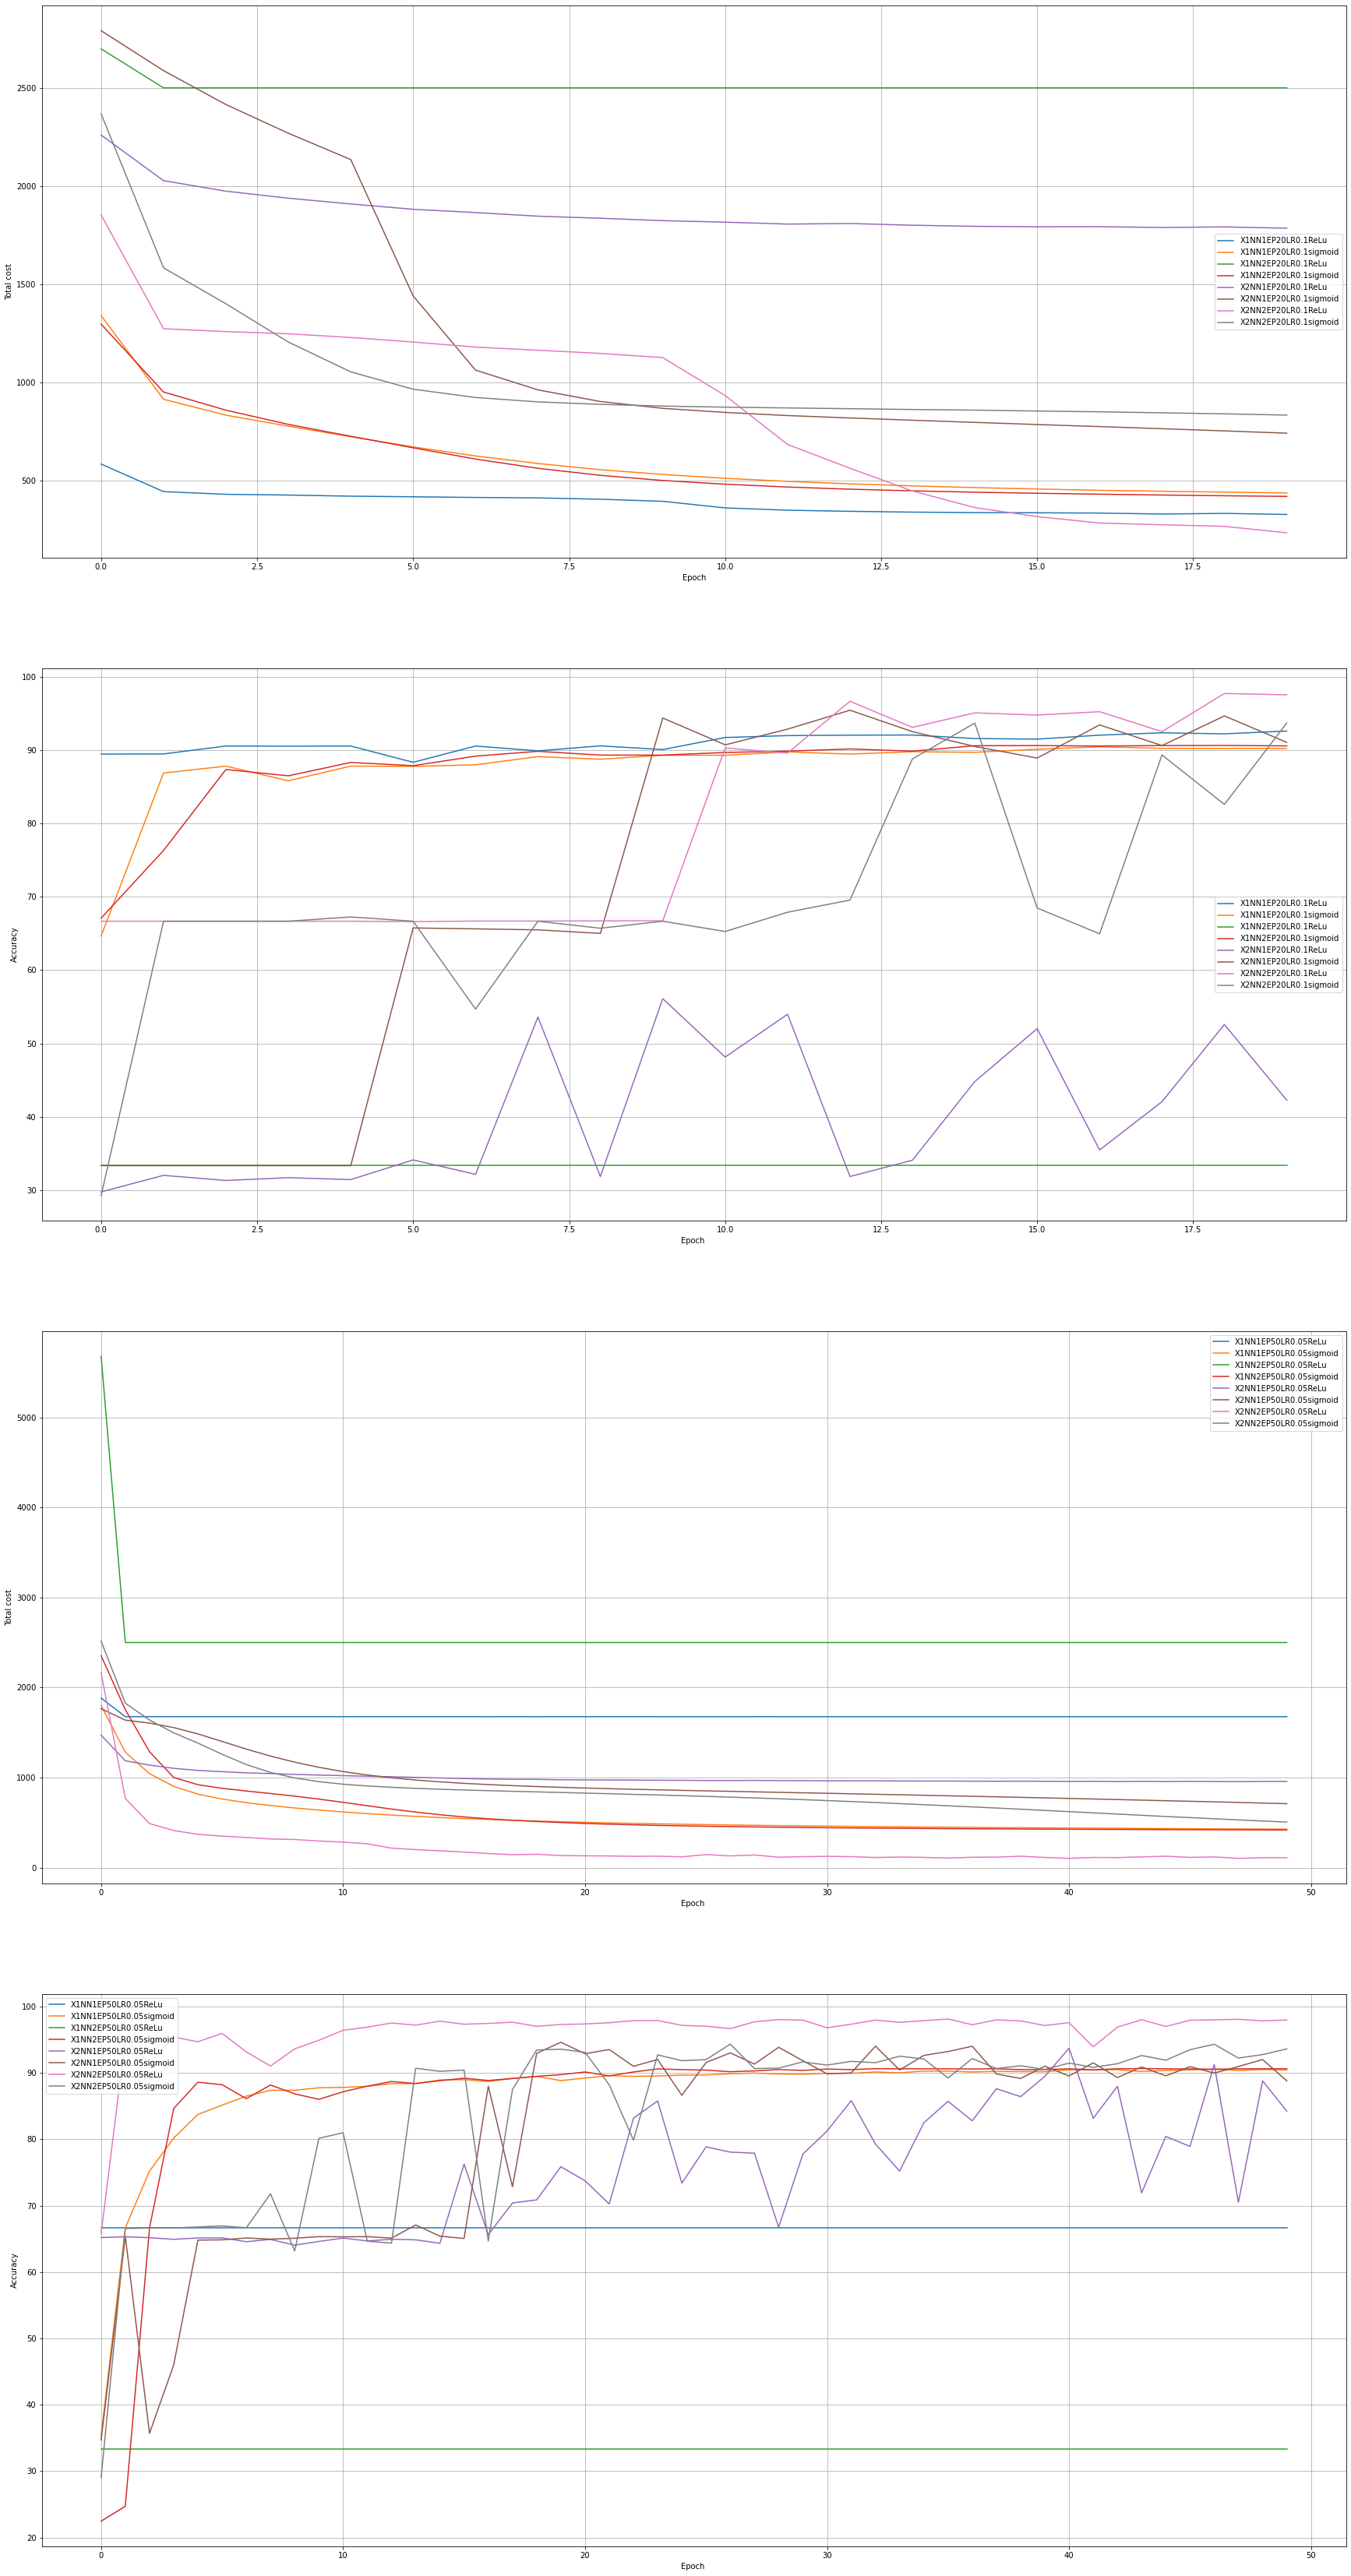

In [38]:
datasets_with_pred = {}

for name, dataset in datasets.items():
    t_before = time.time()    
    print("\n","Training dataset: {}".format(name))
    
    coac_list = []
    # X1.shape = (5000, 2)
    # X2.shape = (5000, 3)
    X1, Y = dataset
    X2 = im_au(X1)
    xx = 1
    pre_list = []
    for X in [X1,X2]:
        # Find number classes
        c  = max(Y) + 1
        # Pre-process the data
        # Checkout the implementation for some cool numpy tricks     
        training_data = pre_process_data(X, Y)
        N1 = [X.shape[1], 7, c]
        N2 = [X.shape[1], 15, 7, c]
        nn = 1
        for N in [N1,N2]:
            for i,j in [[20,0.1],[50,0.05]]:
                for m in ['ReLu','sigmoid']:
                    print("\n","Runnung X : {} - NN : {} - Number of Epochs : {} - Learning Rate : {} - Activation Function : {}".format(xx,nn,i,j,m))
                    #num_layers = len(sizes)
                    #sizes = sizes
                    network = Network(N,m)
                    # network = Network([X.shape[1], 15, 7, c])

                    # training_data, epochs, mini_batch_size, learning_rate
                    #network.train(training_data, 20, 10, 0.1)
                    cost_ar, acc_ar = network.train(training_data, i, 10, j)

                    # for creating dataframe
                    # df = pd.DataFrame({"Total cost":cost_ar, "Accuracy":acc_ar})
                    # print(df)

                    coac_list.append([cost_ar, acc_ar,'X'+str(xx)+'NN'+str(nn)+'EP'+str(i)+'LR'+str(j)+str(m)])
                    predictions = list(map(lambda sample: np.argmax(network.forward(sample[0])[1][-1]), training_data))
                    pre_list.append(['X'+str(xx)+'NN'+str(nn)+'EP'+str(i)+'LR'+str(j)+str(m),predictions])
            # show NN
            nn += 1
        # show X
        xx += 1
    datasets_with_pred[name] = X, Y,pre_list
    t_after = time.time()
    t_training = t_after - t_before
    print("\n","************************************************************************",
          "\n","Time training (seconds): {}".format(t_training),
          "\n","************************************************************************",
          "\n","Now we will compare Learning Curve of X1 and X2 (z = x**2 + y**2)")
    # learning curve
    # make data
    fig, axs = plt.subplots(4)
    for i in coac_list:
        if len(i[0]) == 20:
            x = np.arange(0, len(i[0]))
            axs[0].plot(x, i[0], label = i[2])
            axs[1].plot(x, i[1], label = i[2])
        elif len(i[0]) == 50:
            x = np.arange(0, len(i[0]))
            axs[2].plot(x, i[0], label = i[2])
            axs[3].plot(x, i[1], label = i[2])
    
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Total cost')
    axs[0].grid(True)
    axs[0].legend()
    axs[1].set_xlabel('Epoch ')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    axs[1].legend()
    axs[2].set_xlabel('Epoch ')
    axs[2].set_ylabel('Total cost')
    axs[2].grid(True)
    axs[2].legend()
    axs[3].set_xlabel('Epoch ')
    axs[3].set_ylabel('Accuracy')
    axs[3].grid(True)
    axs[3].legend()
    fig.set_figwidth(30)
    fig.set_figheight(60)
    # axs[0].set_xlim(0, 50)
    # axs[0].set_ylim(0, 2000)
    # axs[1].set_xlim(0, 50)
    # axs[1].set_ylim(0, 100)
    plt.show()

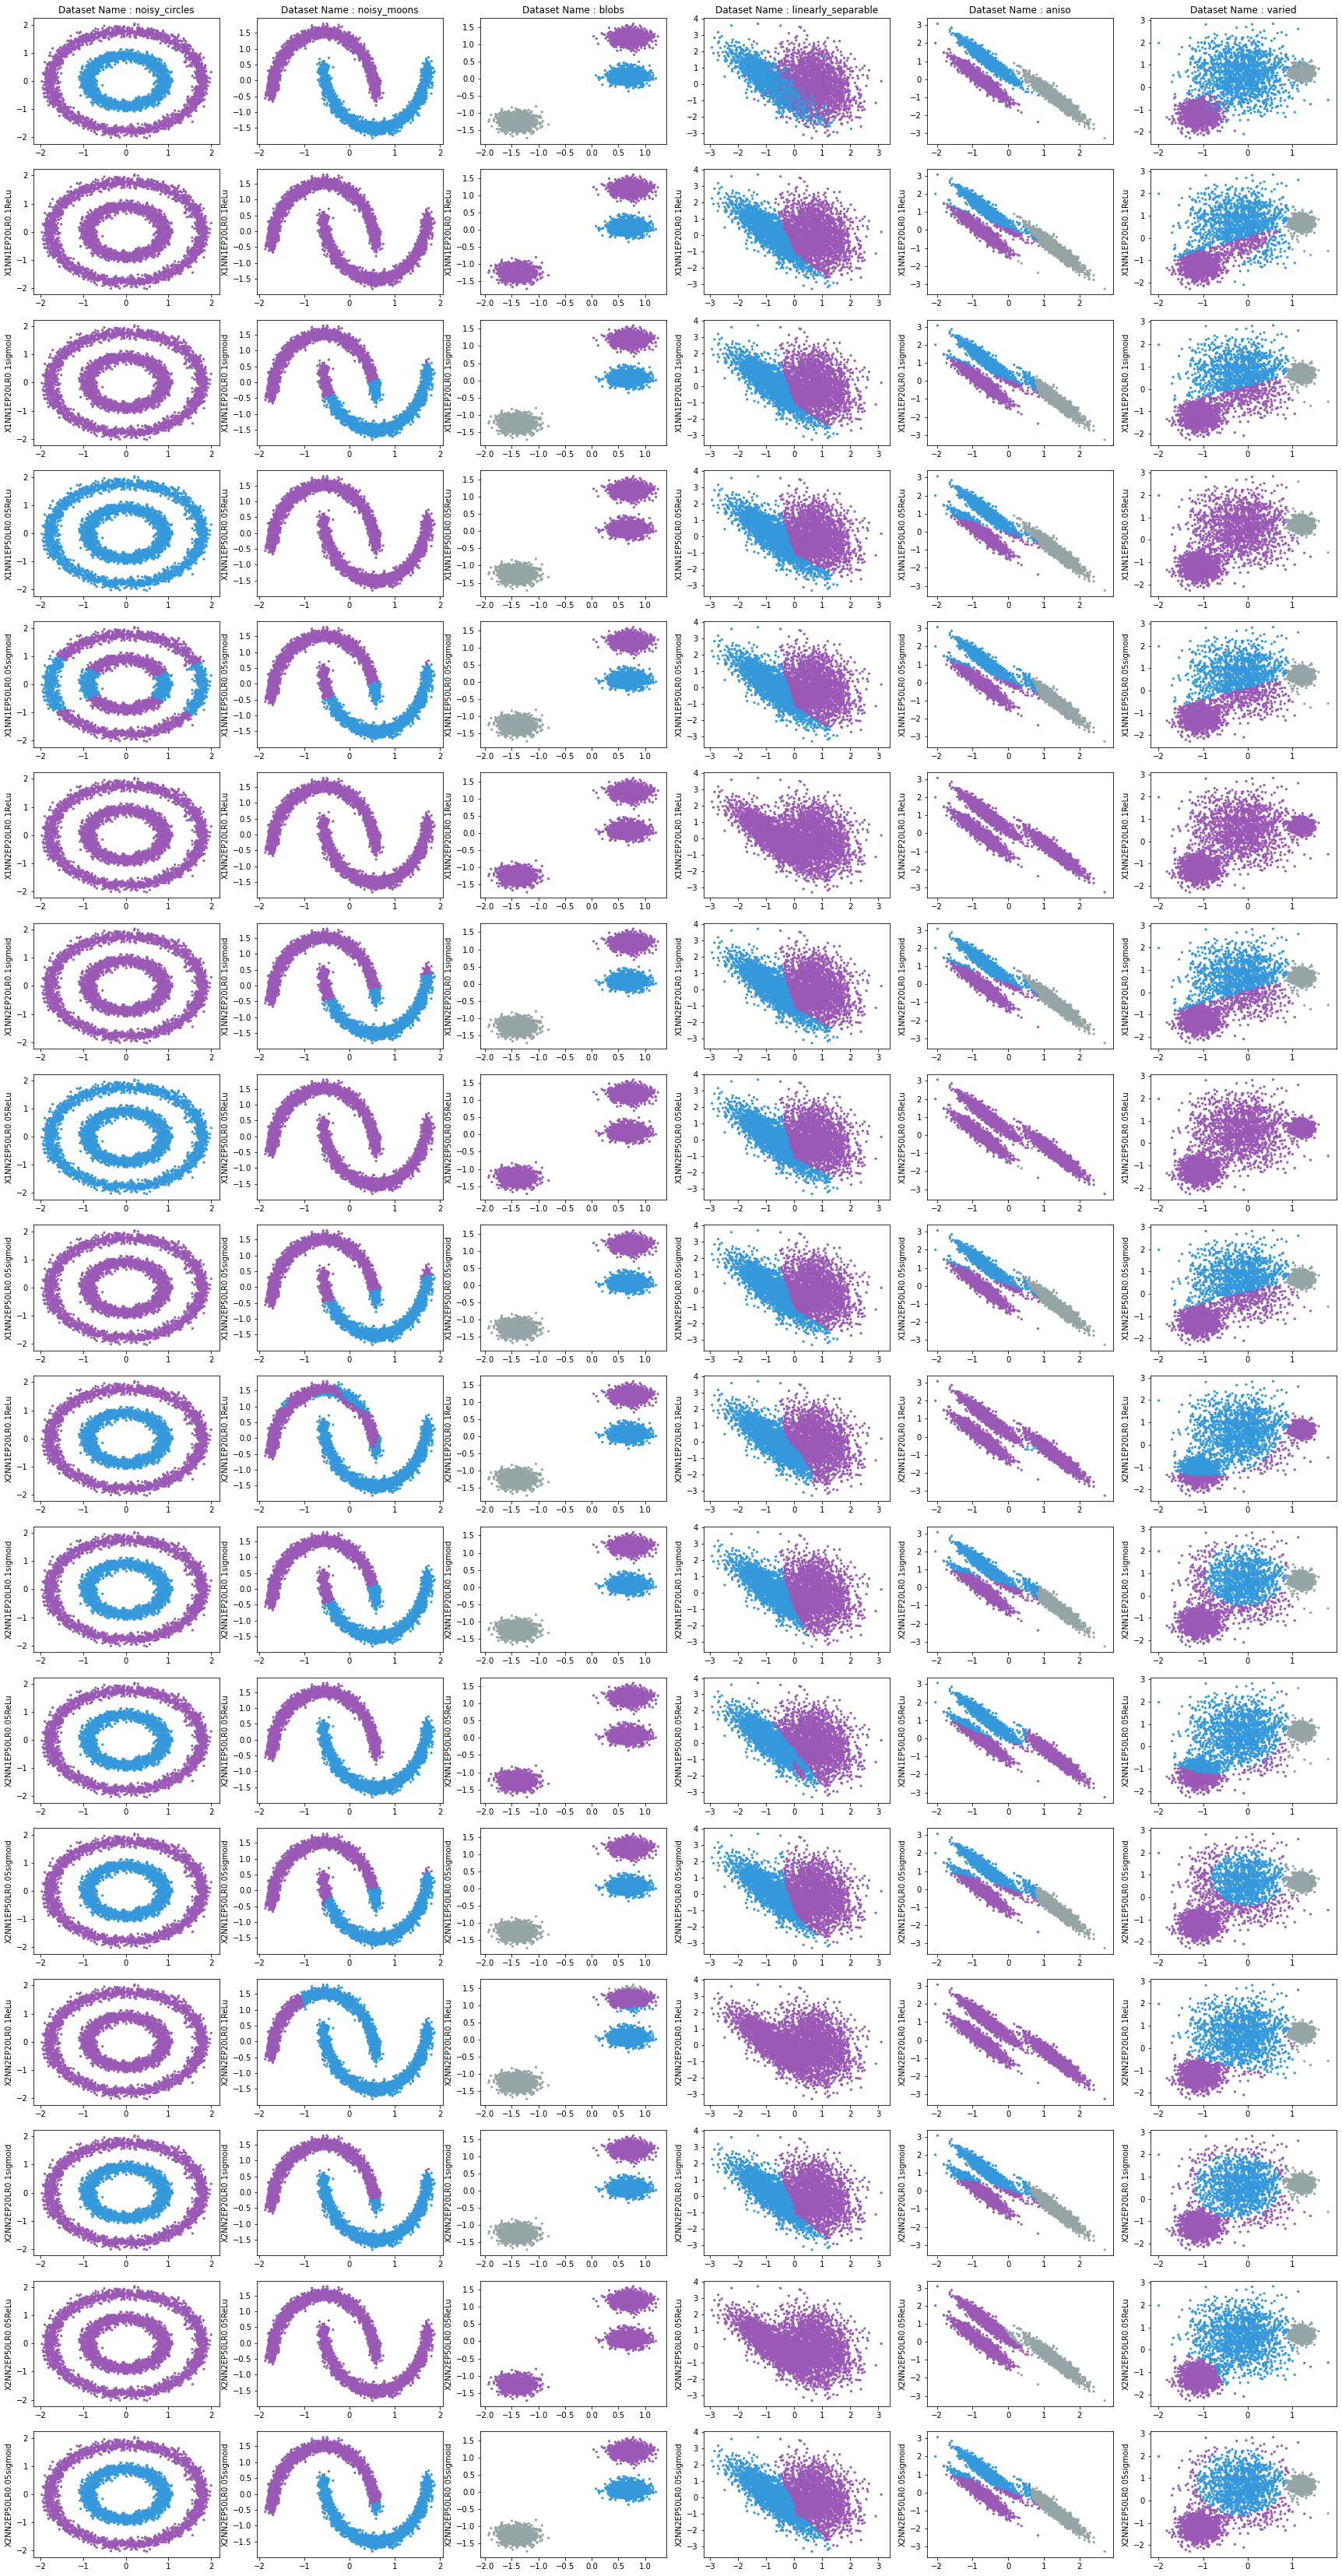

In [39]:
plot_data(datasets_with_pred)

# Discussion

### Part A :
*1. For each data set find the minimal NN architecture. You should set the number of layers, the number of neurons for each layer,  the initialization of weights and bias, the dimension of the mini-batchs, the number of iterations, the learning rate. Discuss your results.*

   - Discuss: for this part of assignment, minimal NN I have chossed one of the NN Parameters which was given in the code and by running them, i got the solutions, there are 8 form in each dataset, Separated by a name wich is:
     
       (parameter (X2 has Z))'X[1,2]'(neural network)'NN[1,2]'(epoche)'EP[20,50]'(learning rate)'LR[0.05,0.1]'(activation functio)'[sigmoid,ReLu]';
       
       The candidates:
       
       1- noisy_circles: X2NN1EP20LR0.1[sigmoid or ReLu]

       2- noisy_moons: X2NN1EP50LR0.05ReLu

       3- blobs: X1NN1EP20LR0.1sigmoid

       4- linearly_separable: X1NN1EP20LR0.05[sigmoid,ReLu]

       5- aniso: X1NN2EP50LR0.05sigmoid or X1NN1EP20LR0.1ReLu

       6- varied: X2NN2EP50LR0.05ReLu or X2NN2EP20LR0.1ReLu


2. Plot the learning curve (Done in final Plots)
*3. Augment the input layer in order to improve learning (e.g., introduce a new synthetic input as the sum of the squares of the two actual inputs:$z=x^2+y^2$). Discuss your results.*
   - Discuss: In  some cases this would be better to use an equation which shown in noisy circle, it can help us to predict better.

### Part B:  (at least one of the following)
4. Increase the size of your NN and implement weigth decay. Discuss your results.
5. Implement drop-out. Discuss your results.
6. Implement layers normalization. Discuss your results.
7. Implement train with noise. Discuss your results.
*8. Change the activation function and its derivative (e.g., try with ReLu). Discuss your results.*
   - Discuss: depends on the dataset when we use ReLu we will get better predictions as shown in learning curves and the plots of data as shown, but there would be a better solution in using Leaky ReLu which has not been discussed here but we can consider it in further Assignments or researchs.